In [1]:
import hera_stats as hs
import hera_pspec as hp
import matplotlib.pyplot as plt
import numpy as np
import os
from hera_stats.data import DATA_PATH

/users/drocha/Python/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
# Settings:

# Import settings
container_path = os.path.join(DATA_PATH, "uvp_data.h5")
pc_group = "IDR2_1"
pc_psnames = None

# Analysis settings
pol = "xx"

# Output settings
pc_out = hp.container.PSpecContainer("./jk_data.h5", "rw")

# PSpec settings
sample_baseline = (0, 1)
bl_tol = 0.1

In [3]:
# Open container
pc = hp.container.PSpecContainer(container_path)

# Get pspecs from list or string
if isinstance(pc_psnames, (tuple, list, np.ndarray)):
    uvp_list = [pc.get_pspec(group=pc_group, psname=ps) for ps in pc_psnames]
else:
    uvp_list = pc.get_pspec(group=pc_group, psname=pc_psnames)

In [4]:
# Redundant baseline calculation, given the sample baseline in cell 2.
uvp = hp.uvpspec.combine_uvpspec(uvp_list)

# Get position and baseline information
pos = uvp.get_ENU_bl_vecs()
all_bls = [uvp.bl_to_antnums(b) for b in uvp.bl_array]
dic = dict(zip(all_bls, pos))

# Find baselines that match the sample_baseline vector very closely
bls = []
for b in all_bls:
    if sum((dic[sample_baseline] - dic[b])**2) < bl_tol:
        bls.append(b)
    else:
        print b

uvp 0 and 1 are concatable across blpairts axis


In [5]:
# Omit antenna jackknife
om_a = hs.jackknives.omit_ants(uvp, None, bls=bls)

In [6]:
# Bootstrap errors
om_a = hs.jackknives.bootstrap_jackknife(om_a, pol=pol)

In [7]:
# Save jackknife
hs.jackknives.save_jackknife(pc_out, om_a, set_jktype="omit_ants")

In [8]:
pc_out.save()

In [9]:
# Create jkset
jk = hs.JKSet(om_a, jktype="omit_ants")
jk

<hera_stats.jkset.JKSet instance at 0x7fd7e823ce90>

Jackknife Data
--------------
jktype: omit_ants
data shape: (1, 31)

In [10]:
# Calculate zscores
zs = hs.stats.zscores(jk, axis=1)

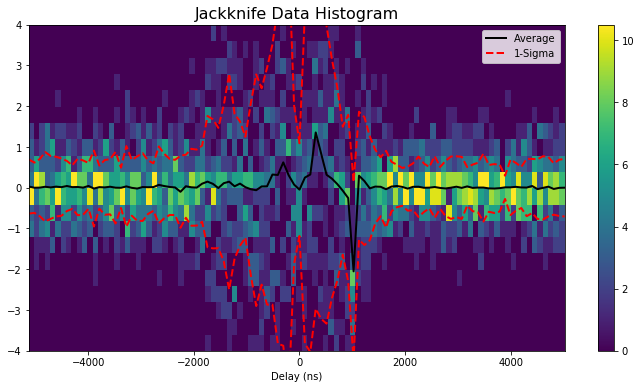

In [11]:
# Plot zscore histogram
hs.plots.hist_2d(zs[0], logscale=False, ylim=(-4,4), ybins=20)

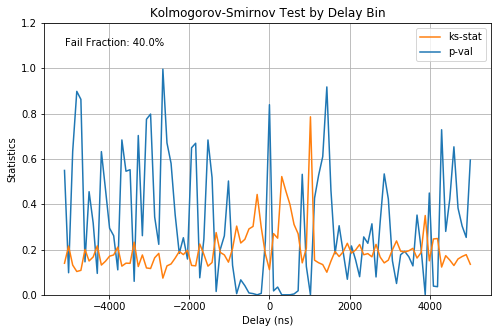

In [12]:
# Test (0, 1) normality
hs.plots.plot_kstest(zs[0])

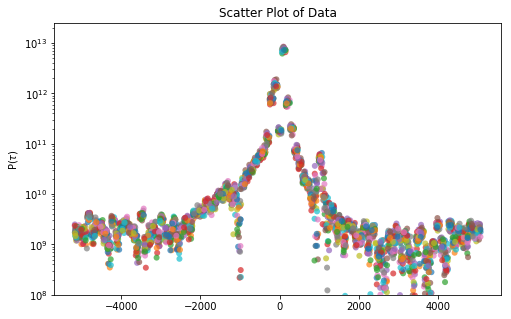

In [13]:
# Look for outliers
hs.plots.scatter(jk[0], ylim=(10**8, 10**12.4))